## Nhóm: 
## Thánh viên
- Bùi Lê Khôi - 22127205
- Nguyễn Thanh Nam - 22127286

### Bối cảnh bài toán 
Trong thực tế, chúng ta thường gặp dữ liệu có **số chiều rất cao** (high-dimensional data):
- **Hình ảnh**: 1 ảnh 256×256 pixels = 65,536 chiều
- **Văn bản**: Mỗi tài liệu có thể được biểu diễn bằng hàng nghìn từ
- **Dữ liệu sinh học**: Gene expression data có thể có hàng chục nghìn chiều
- **Dữ liệu mạng xã hội**: Đồ thị với hàng triệu node

**Vấn đề**: Dữ liệu chiều cao rất khó:
- **Trực quan hóa** (visualize)
- **Phân tích** (analyze)
- **Tính toán** (compute - curse of dimensionality)

**Giải pháp**: **Dimensionality Reduction** (Giảm chiều)
- Chuyển từ không gian chiều cao → không gian chiều thấp (thường 2D hoặc 3D)
- **Bảo toàn cấu trúc** quan trọng của dữ liệu

### Ứng dụng thực tế

#### 1. **Phân tích dữ liệu sinh học**
- **Ví dụ cụ thể**: Phân loại các loại tế bào ung thư từ dữ liệu gene expression
- Có 20,000+ genes (chiều) nhưng chỉ cần 2-3 chiều để phân biệt các loại ung thư khác nhau
- Giúp bác sĩ **chẩn đoán** và chọn **phương pháp điều trị** phù hợp

#### 2. **Nhận dạng khuôn mặt**
- **Ví dụ cụ thể**: Face recognition trong hệ thống bảo mật
- Mỗi ảnh khuôn mặt 100×100 = 10,000 chiều
- Giảm xuống 50-100 chiều để lưu trữ và so sánh nhanh hơn
- Ứng dụng: FaceID trên iPhone, camera an ninh

#### 3. **Phân tích mạng xã hội**
- **Ví dụ cụ thể**: Phát hiện cộng đồng (community detection) trên Facebook/Twitter
- Mỗi người dùng là 1 node trong đồ thị với hàng triệu kết nối
- Giảm chiều để trực quan hóa các nhóm người dùng có mối quan hệ gần nhau
- Ứng dụng: Gợi ý kết bạn, quảng cáo targeted

#### 4. **Xử lý ngôn ngữ tự nhiên**
- **Ví dụ cụ thể**: Word embeddings (Word2Vec, GloVe)
- Từ vocabulary 100,000 từ → vector 300 chiều
- Các từ có nghĩa gần nhau sẽ ở gần nhau trong không gian embedding
- Ứng dụng: Chatbot, máy dịch, tìm kiếm ngữ nghĩa

# Manifold Learning
Manifold Learning (Học đa tạp) là một kỹ thuật quan trọng để giảm chiều dữ liệu phi tuyến tính. Notebook này sẽ thực hiện một nghiên cứu so sánh chi tiết giữa hai thuật toán đại diện cho hai thuật toán khác nhau trên bộ dữ liệu như "Swiss Roll":
- MDS (Multidimensional Scaling): Tập trung bảo toàn khoảng cách toàn cục (Global Distance).
- Spectral Embedding: Tập trung bảo toàn tính chất địa phương/lân cận (Local Connectivity) dựa trên lý thuyết đồ thị.

## 1. Import các thu viện cần thiết

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding, MDS, trustworthiness
from sklearn.datasets import make_swiss_roll, make_s_curve, load_digits, make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global plotting style
plt.style.use('seaborn-v0_8-whitegrid') 

## 2. Tiêu chí đánh giá (Evaluation Metrics)

Để so sánh công bằng, chúng ta sẽ sử dụng 2 chỉ số chính:

### 2.1. Trustworthiness (Độ tin cậy)

Chỉ số này trả lời câu hỏi: "Những điểm đứng cạnh nhau trong không gian mới (2D) có thực sự là hàng xóm của nhau trong không gian gốc hay không?".

- Phạm vi: $0 \to 1$.

- Ý nghĩa: Càng gần 1 càng tốt.

### 2.2. Stress (Độ căng/méo)

Đo lường sự sai lệch về khoảng cách.Công thức chuẩn hóa của Stress:

$$Stress = \sqrt{\frac{\sum_{i,j} (d_{ij} - \hat{d}_{ij})^2}{\sum_{i,j} d_{ij}^2}}$$

Trong đó:
- $d_{ij}$: Khoảng cách trong không gian gốc.
- $\hat{d}_{ij}$: Khoảng cách trong không gian nhúng (embedding).
- Ý nghĩa: Càng thấp càng tốt.

Chúng ta sử dụng `n_neighbors=12` cho hàm `trustworthiness`. 
- Lý do: Đây là con số cân bằng. Nếu chọn $k$ quá nhỏ ($k=1$), chỉ số sẽ bị ảnh hưởng bởi nhiễu. Nếu chọn $k$ quá lớn, nó không còn phản ánh tính chất "địa phương" nữa.
- Stress: Được chuẩn hóa (Normalized) để chúng ta có thể so sánh giữa các bộ dữ liệu có quy mô (scale) khác nhau.

In [22]:
def compute_quality_metrics(X_original, X_embedded):
    """
    Compute quality metrics for the embedding.
    
    Args:
        X_original: Data in high-dimensional space
        X_embedded: Data in low-dimensional space
        
    Returns:
        Dictionary containing metric scores
    """
    # Trustworthiness (higher is better, max=1.0)
    # Checks if k-nearest neighbors are preserved
    # Measures: Did we introduce fake neighbors?
    trust = trustworthiness(X_original, X_embedded, n_neighbors=12)
    
    # Stress calculation (lower is better)
    # Compare pairwise distances in original vs embedded space
    # Measures: How much did we distort the distances?
    D_original = pairwise_distances(X_original)
    D_embedded = pairwise_distances(X_embedded)
    
    # Normalize by original distances to get a scale-invariant score
    stress = np.sqrt(np.sum((D_original - D_embedded)**2) / np.sum(D_original**2))

    # Correlation between distance matrices
    D_orig_flat = D_original[np.triu_indices_from(D_original, k=1)]
    D_emb_flat = D_embedded[np.triu_indices_from(D_embedded, k=1)]
    correlation = np.corrcoef(D_orig_flat, D_emb_flat)[0, 1]
    
    return {
        'trustworthiness': trust,
        'stress': stress,
        'distance_correlation': correlation,
    }

## 3. Thuật toán 1: Multidimensional Scaling (MDS)

MDS cố gắng tìm vị trí các điểm trong không gian chiều thấp sao cho khoảng cách giữa chúng giống nhất với khoảng cách trong không gian gốc.
- Metric MDS: Cố gắng giữ nguyên giá trị khoảng cách (số mét, cm...).
- Non-metric MDS: Chỉ cố gắng giữ nguyên thứ tự khoảng cách (A gần B hơn C).

Tại sao chúng ta cần tham số `metric`?
- `metric=True` (MDS cổ điển): Cố gắng sao chép chính xác khoảng cách. Nó cứng nhắc.
    - Phù hợp: Dữ liệu địa lý (bản đồ thành phố).
- `metric=False` (Non-metric MDS): Chỉ quan tâm đến **thứ tự** (Rank order). Nó cho phép "co giãn" khoảng cách.
    - Phù hợp: Dữ liệu tâm lý học, khảo sát (nơi con số 1-5 chỉ là mức độ, không phải khoảng cách mét).
    - Code: Trong sklearn, `metric=False` kích hoạt thuật toán SMACOF để tối ưu hóa Stress đơn điệu (Monotonic Stress).

In [23]:
def run_mds(X, metric=True, n_components=2):
    """
    Run MDS algorithm and measure performance.
    
    Args:
        X: Input data
        metric: If True use Metric MDS, else Non-metric MDS
        n_components: Target dimensions
    """
    start_time = time.time()
    
    # Initialize MDS
    # max_iter=300 is standard for convergence
    mds = MDS(n_components=n_components, 
              metric=metric, 
              max_iter=300, 
              n_init=4, 
              random_state=42, 
              dissimilarity='euclidean')
    
    # Fit and transform
    X_embedded = mds.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = 'MDS (Metric)' if metric else 'MDS (Non-metric)'
    
    return X_embedded, metrics

## 4. Thuật toán 2: Spectral Embedding

Spectral Embedding (hay Laplacian Eigenmaps) dựa trên lý thuyết phổ đồ thị (Spectral Graph Theory).
- Affinity Matrix ($W$): Xây dựng đồ thị lân cận.
- Laplacian Matrix ($L$): Tính $L = D - W$.
- Eigen-decomposition: Giải phương trình trị riêng $Lf = \lambda Df$. Các vector riêng (eigenvectors) ứng với trị riêng nhỏ nhất sẽ là tọa độ mới.

Phương pháp này cực kỳ mạnh mẽ để "duỗi" các cấu trúc bị cuộn (unfolding manifolds) mà MDS thường thất bại.

Tham số `affinity` quyết định cách đồ thị được xây dựng:
- `affinity='rbf'` (Radial Basis Function):
    - Sử dụng công thức Gaussian: $W_{ij} = e^{-\gamma ||x_i - x_j||^2}$.
    - Tạo ra đồ thị dày đặc (kết nối mềm).
    - Nhược điểm: Với dữ liệu cuộn (Swiss Roll), nó dễ bị "xuyên tường" (nối nhầm 2 lớp giấy gần nhau trong không gian 3D nhưng xa nhau trên bề mặt).
- `affinity='nearest_neighbors'`:
    - Chỉ nối $k$ điểm gần nhất (ví dụ $k=10$).
    - Ưu điểm: Nó cắt bỏ các liên kết xa. Đây là cấu hình **bắt buộc** để "trải phẳng" (unfold) các đa tạp phi tuyến tính như Swiss Roll.

In [24]:
def run_spectral(X, affinity='nearest_neighbors', n_components=2, **kwargs):
    """
    Run Spectral Embedding algorithm.
    
    Args:
        X: Input data
        affinity: 'nearest_neighbors' or 'rbf'
        kwargs: Extra parameters like n_neighbors or gamma
    """
    start_time = time.time()
    
    # Initialize Spectral Embedding
    se = SpectralEmbedding(n_components=n_components, 
                           affinity=affinity,
                           random_state=42,
                           **kwargs)
    
    # Fit and transform
    X_embedded = se.fit_transform(X)
    embedding_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_quality_metrics(X, X_embedded)
    metrics['time'] = embedding_time
    metrics['method'] = f'Spectral ({affinity})'
    
    return X_embedded, metrics

## 5. Chuẩn bị Dữ liệu & Hàm so sánh

In [25]:
def compare_and_visualize(X, y, dataset_name):
    """
    Run both algorithms on the dataset and plot results side-by-side.
    """
    print(f"Processing: {dataset_name} (Shape: {X.shape})...")
    
    # 1. Run Spectral Embedding (using nearest_neighbors is best for unfolding)
    X_se, m_se = run_spectral(X, affinity='nearest_neighbors', n_neighbors=15)
    
    # 2. Run Metric MDS
    X_mds, m_mds = run_mds(X, metric=True)
    
    # 3. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot Original (First 2 dim or 3D projection logic if needed, here simplified)
    # Note: For true 3D viz we need Axes3D, but for simple comparison 
    # we often plot the embedding result directly.
    # Let's plot the embeddings.
    
    # Helper to plot
    def plot_emb(ax, data, labels, title, metrics):
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='Spectral', s=15, alpha=0.7)
        subtitle = f"Trust: {metrics['trustworthiness']:.3f}, Stress: {metrics['stress']:.3f}"
        ax.set_title(f"{title}\n{subtitle}")
        ax.grid(True, alpha=0.3)

    # We will plot a 3D view for the original data if it is 3D
    if X.shape[1] == 3:
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='Spectral', s=15)
        ax1.set_title(f"Original 3D Data\n{dataset_name}")
        ax1.view_init(10, -70) # Good angle for Swiss Roll
    else:
        # For high dim data like digits, we skip 3D plot or use PCA for preview
        axes[0].text(0.5, 0.5, "High-Dim Data\nNo 3D View", ha='center')
    
    # Plot MDS
    plot_emb(axes[1], X_mds, y, "Metric MDS", m_mds)
    
    # Plot Spectral
    plot_emb(axes[2], X_se, y, "Spectral Embedding", m_se)
    
    plt.tight_layout()
    plt.show()
    
    # Print textual summary
    print(f"--- Summary for {dataset_name} ---")
    print(f"MDS      -> Trust: {m_mds['trustworthiness']:.4f}, Time: {m_mds['time']:.4f}s")
    print(f"Spectral -> Trust: {m_se['trustworthiness']:.4f}, Time: {m_se['time']:.4f}s")
    print("-" * 50 + "\n")

## 6. Bài toán 1: Swiss Roll

Đây là bộ dữ liệu chuẩn mực (Benchmark) cho Manifold Learning. Nó là một mặt phẳng 2D bị cuộn tròn trong 3D.
- Dự đoán: MDS sẽ thất bại (ép bẹp cuộn giấy). Spectral sẽ thành công (trải phẳng cuộn giấy).

Generating Swiss Roll data...
Processing: Swiss Roll (Shape: (1000, 3))...


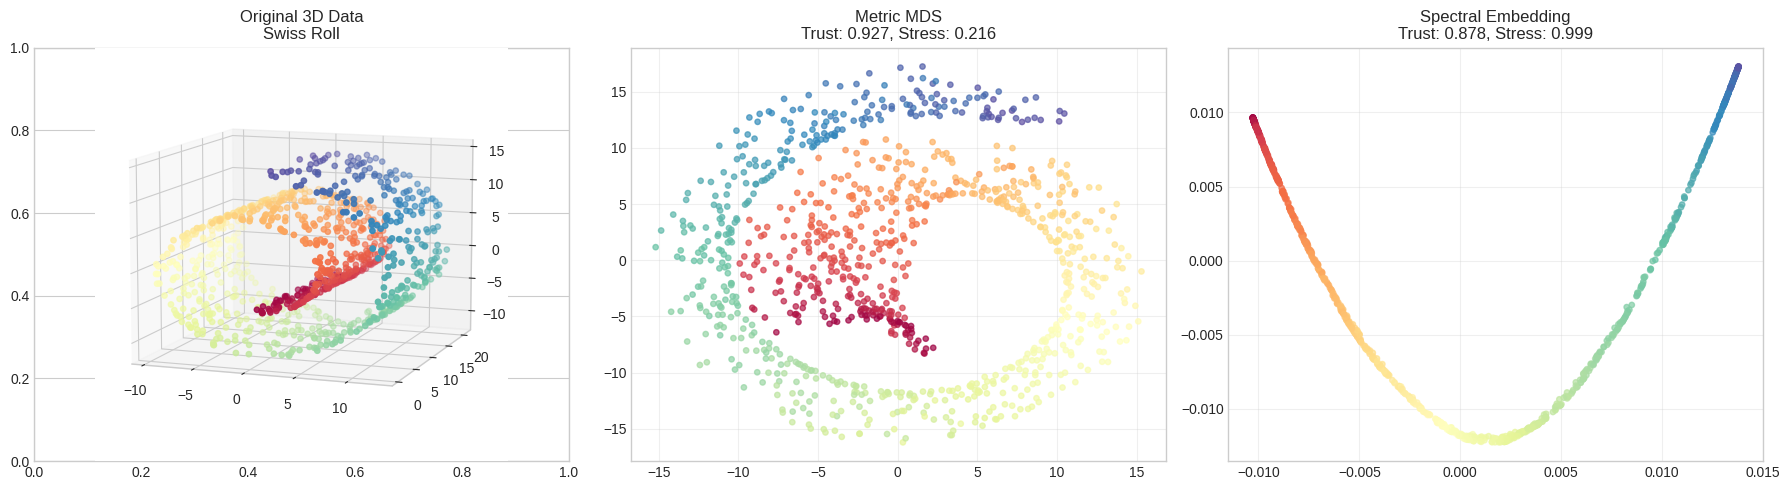

--- Summary for Swiss Roll ---
MDS      -> Trust: 0.9271, Time: 7.6964s
Spectral -> Trust: 0.8782, Time: 0.0572s
--------------------------------------------------



In [26]:
# Generate Swiss Roll data
print("Generating Swiss Roll data...")
X_swiss, y_swiss = make_swiss_roll(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
compare_and_visualize(X_swiss, y_swiss, "Swiss Roll")

## 7. Bài toán 2: S-Curve

Tương tự như Swiss Roll nhưng hình dạng chữ S. Đây cũng là một đa tạp phi tuyến tính điển hình.

Generating S-Curve data...
Processing: S-Curve (Shape: (1000, 3))...


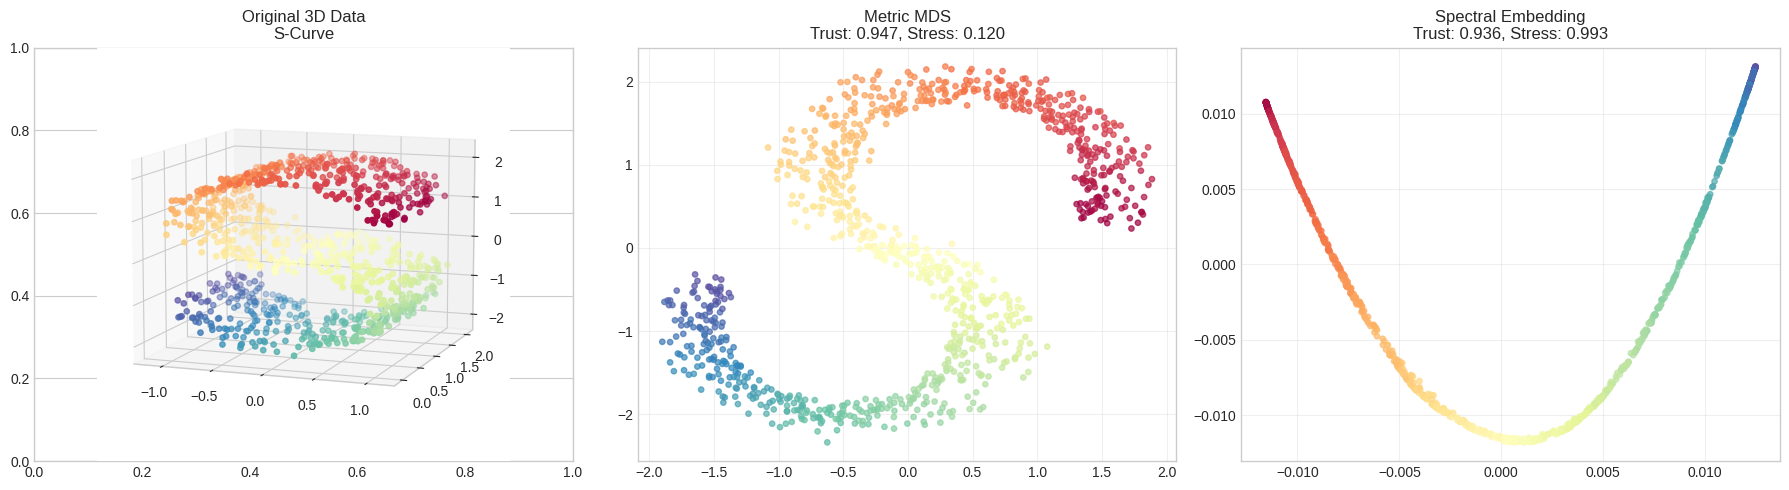

--- Summary for S-Curve ---
MDS      -> Trust: 0.9467, Time: 7.4538s
Spectral -> Trust: 0.9363, Time: 0.0365s
--------------------------------------------------



In [27]:
# Generate S-Curve data
print("Generating S-Curve data...")
X_scurve, y_scurve = make_s_curve(n_samples=1000, noise=0.05, random_state=42)

# Run comparison
compare_and_visualize(X_scurve, y_scurve, "S-Curve")

## 8. Bài toán 3: Dữ liệu số viết tay (Digits)

Đây là dữ liệu thực tế gồm các ảnh 8x8 pixel (64 chiều). Chúng ta xem các thuật toán phân cụm các số (0-9) như thế nào.

Loading Digits dataset...
Processing: Digits (64D) (Shape: (1797, 64))...


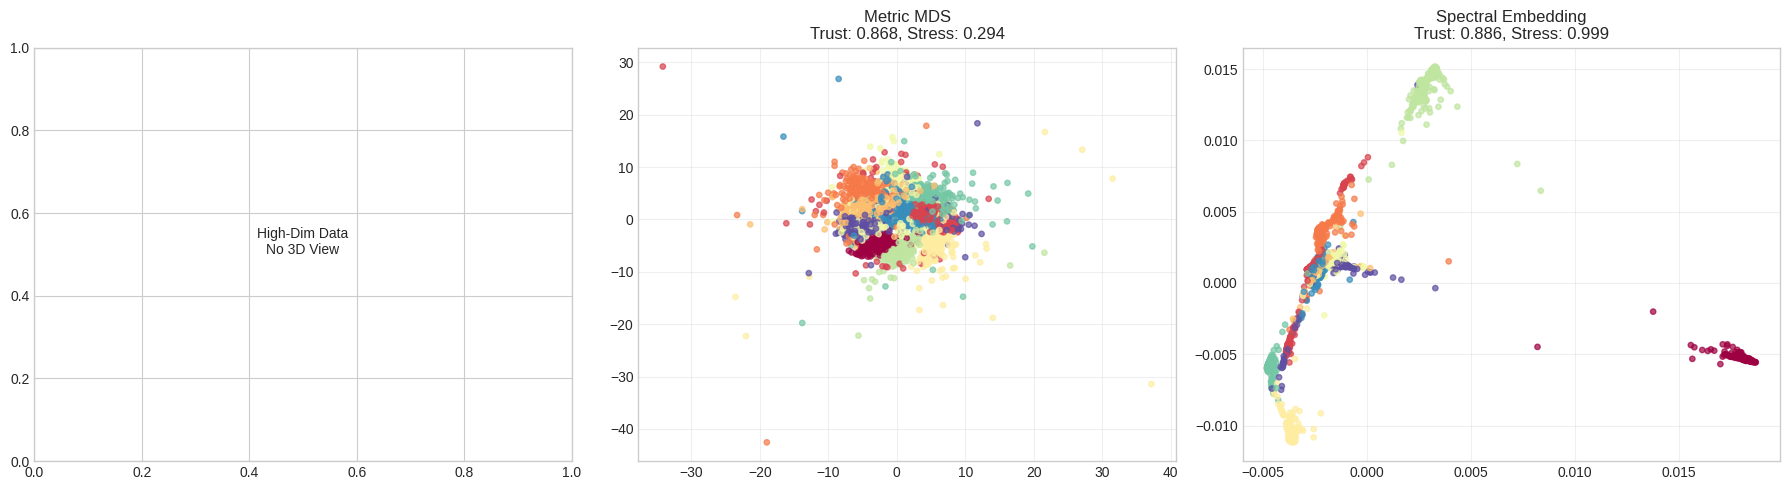

--- Summary for Digits (64D) ---
MDS      -> Trust: 0.8682, Time: 74.0773s
Spectral -> Trust: 0.8858, Time: 0.1851s
--------------------------------------------------



In [28]:
# Load Digits data
print("Loading Digits dataset...")
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

# Standardize features (important for distance calculations)
X_digits = StandardScaler().fit_transform(X_digits)

# Run comparison
compare_and_visualize(X_digits, y_digits, "Digits (64D)")

## 9. Ablation Study

Phần này chúng ta sẽ xem xét tham số n_neighbors ảnh hưởng thế nào đến chất lượng của Spectral Embedding.
- Nếu $k$ quá nhỏ: Đồ thị bị rời rạc.
- Nếu $k$ quá lớn: Các kết nối "tắt" xuất hiện làm sai lệch cấu trúc hình học.

Running Ablation Study on n_neighbors...
k=5: Trust=0.938
k=10: Trust=0.888
k=20: Trust=0.944
k=50: Trust=0.910
k=100: Trust=0.916


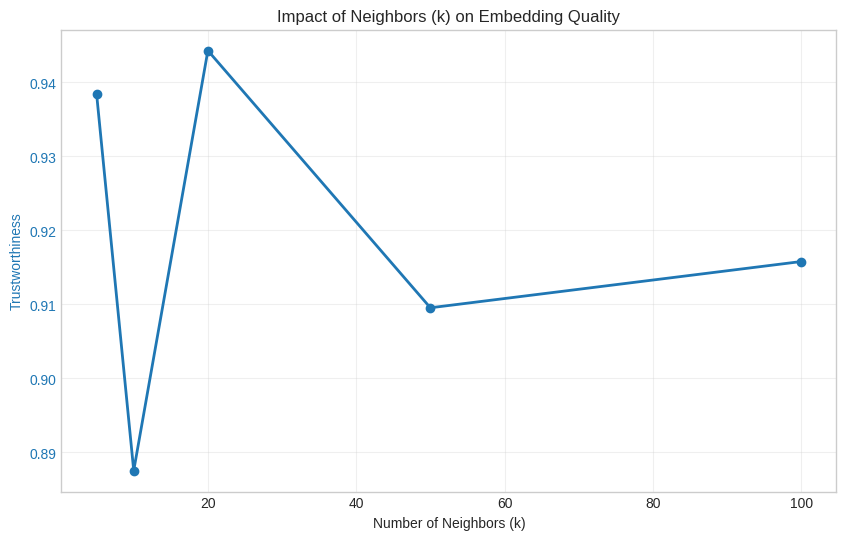

In [29]:
def ablation_study_neighbors(X, y):
    """
    Study how n_neighbors affects Spectral Embedding performance.
    """
    neighbors_list = [5, 10, 20, 50, 100]
    trust_scores = []
    stress_scores = []
    
    print("Running Ablation Study on n_neighbors...")
    
    for k in neighbors_list:
        # Run Spectral with specific k
        se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=k)
        X_emb = se.fit_transform(X)
        
        # Calculate metrics
        metrics = compute_quality_metrics(X, X_emb)
        trust_scores.append(metrics['trustworthiness'])
        stress_scores.append(metrics['stress'])
        print(f"k={k}: Trust={metrics['trustworthiness']:.3f}")

    # Plotting results
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Neighbors (k)')
    ax1.set_ylabel('Trustworthiness', color=color)
    ax1.plot(neighbors_list, trust_scores, marker='o', color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Impact of Neighbors (k) on Embedding Quality")
    ax1.grid(True, alpha=0.3)

    plt.show()

# Run ablation on Swiss Roll
ablation_study_neighbors(X_swiss, y_swiss)

Hãy xem điều gì xảy ra với Swiss Roll nếu ta chọn sai cấu hình `affinity='rbf'` cho Spectral Embedding.
- Kỳ vọng: Nó sẽ thất bại, không trải được cuộn giấy ra, hoặc làm méo mó dữ liệu.

Demonstrating the impact of wrong configuration on Swiss Roll...


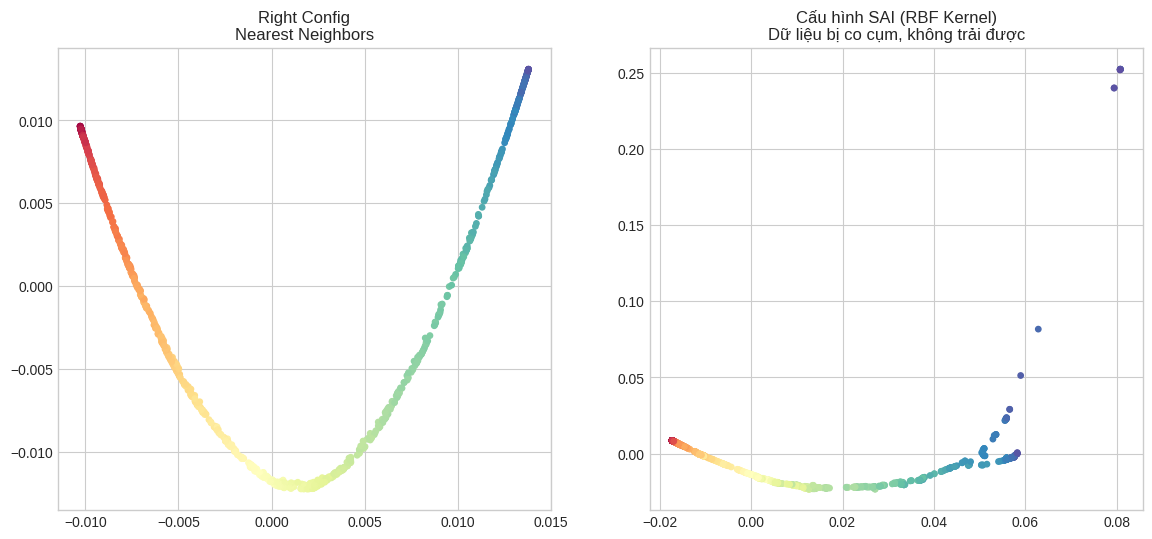

In [ ]:
def demonstrate_config_impact(X, y):
    print("Demonstrating the impact of wrong configuration on Swiss Roll...")
    
    # Correct Config: Nearest Neighbors
    se_correct = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=15)
    X_correct = se_correct.fit_transform(X)
    
    # Wrong Config: RBF (Gaussian Kernel)
    # Gamma=1.0 makes it look at Euclidean distances globally in a radius
    se_wrong = SpectralEmbedding(n_components=2, affinity='rbf', gamma=1.0)
    X_wrong = se_wrong.fit_transform(X)
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.scatter(X_correct[:, 0], X_correct[:, 1], c=y, cmap='Spectral', s=15)
    ax1.set_title("Cấu hình ĐÚNG (Nearest Neighbors)\nTrải phẳng thành công")
    
    ax2.scatter(X_wrong[:, 0], X_wrong[:, 1], c=y, cmap='Spectral', s=15)
    ax2.set_title("Cấu hình SAI (RBF Kernel)\nDữ liệu bị co cụm, không trải được")
    
    plt.show()


demonstrate_config_impact(X_swiss, y_swiss)

## 10. Kết luận

### 10.1. Về hình học (Geometry):
- Spectral Embedding vượt trội với các dữ liệu dạng cuộn (Swiss Roll, S-Curve) nhờ khả năng "duỗi" cấu trúc dựa trên lân cận. Nó có chỉ số Trustworthiness rất cao.
- MDS gặp khó khăn với dữ liệu phi tuyến tính phức tạp, thường làm chồng chéo các điểm dữ liệu (Stress thấp nhưng Trustworthiness thấp).

### 10.2. Về ứng dụng:
- Dùng Spectral Embedding cho các bài toán Manifold Learning phức tạp (Image manifold, chuyển động robot).
- Dùng MDS khi muốn trực quan hóa sự khác biệt về khoảng cách giữa các đối tượng rời rạc (ví dụ: bản đồ khoảng cách các thành phố, sự khác biệt gene).